In [1]:
import argparse
import json
import pandas as pd
import numpy as np
from simpletransformers.classification import ClassificationModel
import torch
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from string import punctuation
import matplotlib.pyplot as plt
import contractions
import nltk
nltk.download('stopwords')
nltk.download('punkt')
plt.style.use('ggplot')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/arsenchik/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/arsenchik/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Data analysis

In [2]:
def load_input(df):
    if type(df) != pd.DataFrame:
        df = pd.read_json(df, lines=True)
    
    ret = []
    for _, i in df.iterrows():
        ret += [{'text': ' '.join(i['postText']) + ' - ' + i['targetTitle'] + ' ' + ' '.join(i['targetParagraphs']),
                 'uuid': i['uuid'],
                  'target' : i['tags'][0]}]
    
    return pd.DataFrame(ret)

def expand_words(text):
    expanded_words = []   
    for word in text:
        expanded_words.append(contractions.fix(word))  
    
    return expanded_words

In [3]:
train = load_input('train.jsonl')
test = load_input('validation.jsonl')

noise = stopwords.words('english') + list(punctuation) + ['«', '»', '``', '\'\'', '–', '—', '’']
train['text_tokenized'] = train['text'].str.replace('\n', ' ').str.lower().str.strip().apply(lambda x: word_tokenize(x, language='english'))
train['text_tokenized'] = train['text_tokenized'].apply(lambda x: [w for w in x if w not in noise])
train['text_tokenized'] = train['text_tokenized'].apply(lambda x: expand_words(x))
test['text_tokenized'] = test['text'].str.replace('\n', ' ').str.lower().str.strip().apply(lambda x: word_tokenize(x, language='english'))
test['text_tokenized'] = test['text_tokenized'].apply(lambda x: [w for w in x if w not in noise])
test['text_tokenized'] = test['text_tokenized'].apply(lambda x: expand_words(x))

X_train, y_train = train['text_tokenized'].apply(lambda x : ' '.join(x)).values, train['target'].values
X_test, y_test = test['text_tokenized'].apply(lambda x : ' '.join(x)).values, test['target'].values

In [6]:
## классы несбалансированы

train['target'].value_counts()

phrase     1367
passage    1274
multi       559
Name: target, dtype: int64

In [13]:
## Выборочно проверили на опечатки в ворде, опечаток не обнаружено :) 

In [7]:
## найдем топ 300 слов по встречаемости во всех предложениях
top300 = train['text_tokenized'].explode().value_counts().head(300)
top20 = top300.head(20)
top300

's        11606
one        5309
said       4654
n't        4326
people     4229
          ...  
free        434
behind      433
major       431
donald      431
whole       430
Name: text_tokenized, Length: 300, dtype: int64

In [8]:
## найдем топ 5 слов по встречаемости во всех предложениях по классам
top300 = train.groupby('target')['text_tokenized'].apply(lambda x : x.explode().value_counts().head(5))
pd.DataFrame(top300)

text_tokenized
target                        
multi   's                2542
        one               1403
        n't               1205
        people            1177
        like              1071
passage 's                4477
        one               1986
        said              1871
        inc.              1854
        like              1656
phrase  's                4587
        one               1920
        said              1915
        n't               1533
        like              1412

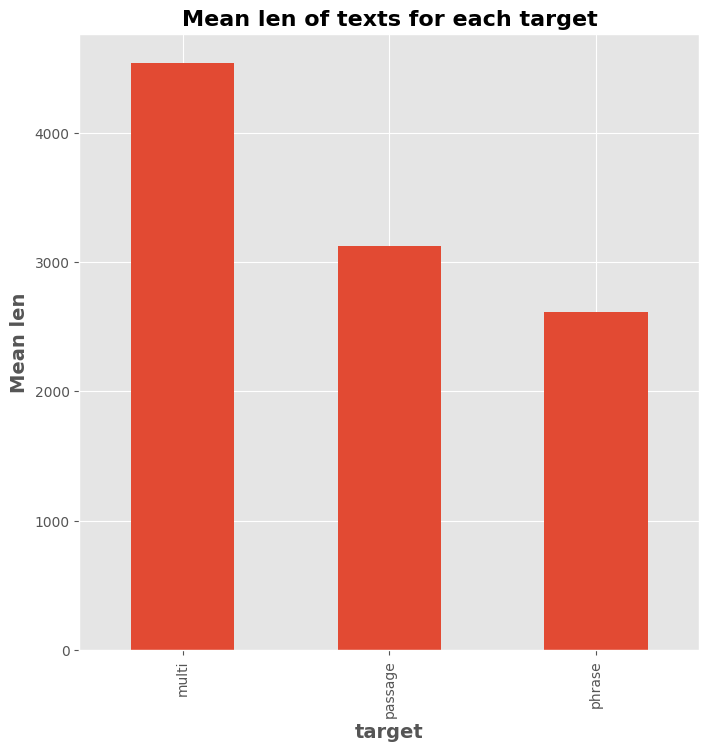

In [9]:
import matplotlib.pyplot as plt
train['len_text'] = train['text'].str.len()

plt.style.use('ggplot')
plt.figure(figsize=(8, 8))

plt.title('Mean len of texts for each target', size=16, weight='bold')

plt.xlabel('Target', size=14, weight='bold')
plt.ylabel('Mean len', size=14, weight='bold')

train['len_text'] = train['text'].str.len()
train.groupby('target')['len_text'].mean().sort_values(ascending=False).plot.bar()

plt.show()

## Средняя длина текста ментше в фразах и больше в multi, что вполне закономерно

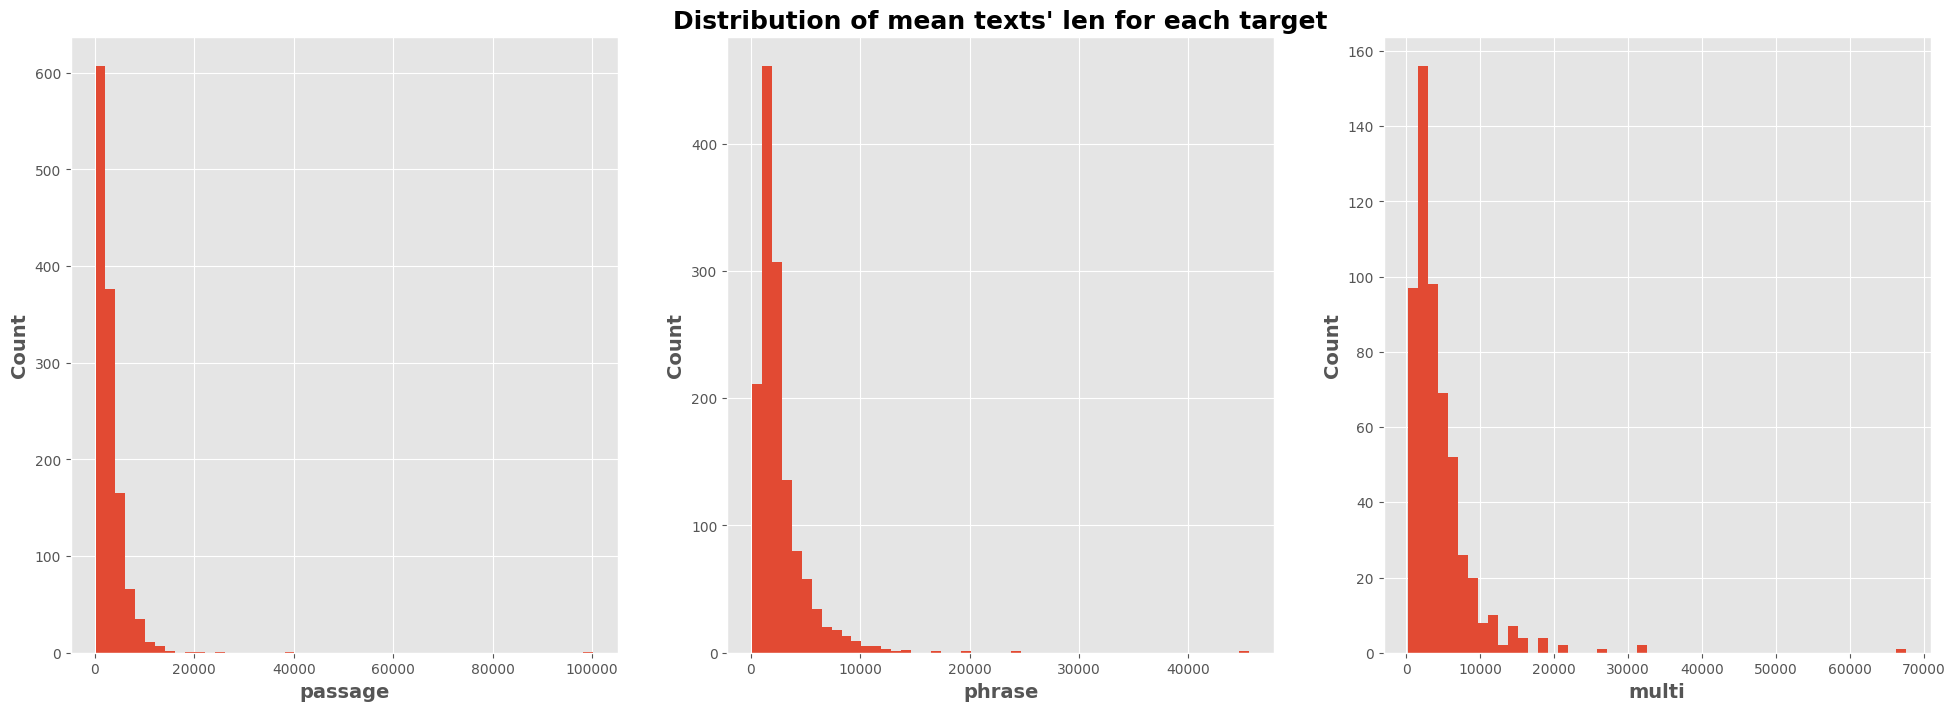

In [10]:
fig, axs = plt.subplots(1, 3, figsize=(24, 8))

axs[1].set_title('Distribution of mean texts\' len for each target', size=18, weight='bold')

for i, target in enumerate(train['target'].unique()):
    train[train['target'] == target]['len_text'].plot.hist(ax=axs[i], bins=50)
    
    axs[i].set_xlabel(target, size=14, weight='bold')
    axs[i].set_ylabel('Count', size=14, weight='bold')

## Baselines

В соревновании был предоставлен код для получения двух бейзлайнов:

Baseline1 - предсказание одного класса "passage"

Baseline2 - предсказания, полученные с помощью fine-tuned трансформера

Посчитаем бейзлайны:

In [18]:
from sklearn.metrics import f1_score

y_pred = np.full(len(y_test), 'passage')
print('Macro F1 for baseline1:', f1_score(y_test, y_pred, average='macro'))

Macro F1 for baseline1: 0.19132501485442663


In [19]:
def use_cuda():
    return torch.cuda.is_available() and torch.cuda.device_count() > 0

def predict(df):
    df = load_input(df)
    labels = ['phrase', 'passage', 'multi']
    model = ClassificationModel('deberta', '/kaggle/input/webisclickbait/spoiler-type-classification', use_cuda=use_cuda())

    uuids = list(df['uuid'])
    texts = list(df['text'])
    predictions = model.predict(texts)[1]
    
    for i in range(len(df)):
        yield {'uuid': uuids[i], 'spoilerType': labels[np.argmax(predictions[i])]}

def run_baseline(input_file, output_file):
    predictions = []
    for prediction in predict(input_file):
        predictions.append(prediction)
    return predictions

In [20]:
pred = run_baseline('/kaggle/input/webisclickbait/webis-clickbait-22/validation.jsonl', 'res.jsonl')
pred = list(map(lambda x : x['spoilerType'], pred))

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

In [21]:
from sklearn.metrics import f1_score

y_true = load_input('/kaggle/input/webisclickbait/webis-clickbait-22/validation.jsonl')['target']
print('Macro F1 for baseline2:' ,f1_score(y_true, pred, average='macro'))

Macro F1 for baseline2: 0.7385822029349418


## Наша модель

In [23]:
## 5-folds CV

In [50]:
for fold in range(5):
    with open(f'data.train_fold{fold + 1}.txt', 'w', encoding='utf-8') as outfile:
        for i in np.delete(np.arange(X_train.shape[0]), np.arange(fold * X_train.shape[0] // 5, (fold + 1) * X_train.shape[0] // 5)):
            outfile.write('__label__' + y_train[i] + ' '+ X_train[i] + '\n')

In [67]:
import fasttext
from tqdm.notebook import tqdm

scores = []
epochs = [5, 10, 20, 30, 50]

for epoch in tqdm(epochs):
    scores.append([])
    for fold in range(5):
        classifier = fasttext.train_supervised(f'data.train_fold{fold + 1}.txt', epoch=epoch)
        y_pred = classifier.predict(X_train[fold * X_train.shape[0] // 5: (fold + 1) * X_train.shape[0] // 5].tolist())
        score = f1_score(np.array(list(map(lambda x : "__label__" + x,
                                y_train[fold * X_train.shape[0] // 5: (fold + 1) * X_train.shape[0] // 5]))),
                                np.array(y_pred[0]).squeeze(), average='macro')
        scores[-1].append(score)

  0%|          | 0/5 [00:00<?, ?it/s]

Read 0M words
Number of words:  56644
Number of labels: 3
Progress: 100.0% words/sec/thread: 5176195 lr:  0.000000 avg.loss:  1.100602 ETA:   0h 0m 0s
Read 0M words
Number of words:  60687
Number of labels: 3
Progress: 100.0% words/sec/thread: 5274725 lr:  0.000000 avg.loss:  1.099013 ETA:   0h 0m 0s
Read 0M words
Number of words:  61190
Number of labels: 3
Progress: 100.0% words/sec/thread: 4028152 lr:  0.000000 avg.loss:  1.098850 ETA:   0h 0m 0s
Read 0M words
Number of words:  60802
Number of labels: 3
Progress: 100.0% words/sec/thread: 5133986 lr:  0.000000 avg.loss:  1.099810 ETA:   0h 0m 0s
Read 0M words
Number of words:  61468
Number of labels: 3
Progress: 100.0% words/sec/thread: 5159489 lr:  0.000000 avg.loss:  1.099296 ETA:   0h 0m 0s
Read 0M words
Number of words:  56644
Number of labels: 3
Progress: 100.0% words/sec/thread: 5147142 lr:  0.000000 avg.loss:  1.062831 ETA:   0h 0m 0s
Read 0M words
Number of words:  60687
Number of labels: 3
Progress: 100.0% words/sec/thread: 4

In [69]:
scores = np.array(scores)
scores

array([[0.20837809, 0.19521179, 0.19100706, 0.20188816, 0.20087336],
       [0.20837809, 0.19521179, 0.19100706, 0.20188816, 0.20087336],
       [0.33924742, 0.34832921, 0.30679876, 0.3435452 , 0.35240257],
       [0.49068761, 0.46627909, 0.45879365, 0.43958607, 0.48307471],
       [0.48118693, 0.45495829, 0.46358096, 0.45237287, 0.5027806 ]])

In [71]:
scores = scores.mean(axis=1)

Text(0, 0.5, 'f1')

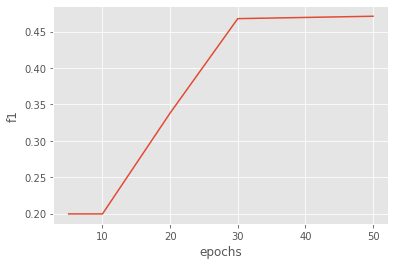

In [72]:
plt.plot(epochs, scores)
plt.xlabel('epochs')
plt.ylabel('f1')

In [74]:
best_epoch = 50

with open('data.train.txt', 'w', encoding='utf-8') as outfile:
    for i in range(len(X_train)):
        outfile.write('__label__' + y_train[i] + ' '+ X_train[i] + '\n')
        
classifier = fasttext.train_supervised('data.train.txt', epoch=best_epoch)

Read 0M words
Number of words:  68227
Number of labels: 3
Progress: 100.0% words/sec/thread: 4865597 lr:  0.000000 avg.loss:  0.445100 ETA:   0h 0m 0s


In [75]:
y_pred = classifier.predict(X_test.tolist())
print('Macro F1:', f1_score(np.array(list(map(lambda x : "__label__" + x, y_test))),
                            np.array(y_pred[0]).squeeze(), average='macro'))

Macro F1: 0.46217413313852723


Наша базовая модель побила baseline1, однако далека от второго бейзлайна.

In [5]:
train = train.rename(columns={"target":"label"})
test = test.rename(columns={"target":"label"})

In [6]:
mapper = {"passage": 0, "phrase":1, "multi":2}
train["label"] = train["label"].replace(mapper)
train

,text,uuid,label,text_tokenized
0,"Wes Welker Wanted Dinner With Tom Brady, But P...",0af11f6b-c889-4520-9372-66ba25cb7657,0,"[wes, welker, wanted, dinner, tom, brady, patr..."
1,NASA sets date for full recovery of ozone hole...,b1a1f63d-8853-4a11-89e8-6b2952a393ec,1,"[nasa, sets, date, full, recovery, ozone, hole..."
2,This is what makes employees happy -- and it's...,008b7b19-0445-4e16-8f9e-075b73f80ca4,1,"[makes, employees, happy, --, 's, paycheck, in..."
3,Passion is overrated — 7 work habits you need ...,31ecf93c-3e21-4c80-949b-aa549a046b93,2,"[passion, overrated, 7, work, habits, need, in..."
4,The perfect way to cook rice so that it's perf...,31b108a3-c828-421a-a4b9-cf651e9ac859,1,"[perfect, way, cook, rice, 's, perfectly, fluf..."
...,...,...,...,...
3195,Has Facebook's video explosion completely shak...,92578045-699f-4957-a3c5-cff2c3874dae,0,"[facebook, 's, video, explosion, completely, s..."
3196,Cop Is Eating At A Chili's When Teen Hands Him...,51682121-df0b-4289-a95f-e1bc3d181306,0,"[cop, eating, chili, 's, teen, hands, folded, ..."
3197,5 popular myths about visible signs of aging t...,9c45ca67-38c4-47b4-aa0d-48434bae09fc,2,"[5, popular, myths, visible, signs, aging, bog..."
3198,You need to see this Twitter account that pred...,9d05984c-3920-47c0-aa97-8df58cca1fec,1,"[need, see, twitter, account, predicted, beyon..."


In [7]:
test["label"] = test["label"].replace(mapper)
test.head(3)

,text,uuid,label,text_tokenized
0,Five Nights at Freddy’s Sequel Delayed for Wei...,6dc7ddef-4e8e-4a6b-9296-526377518071,0,"[five, nights, freddy, sequel, delayed, weird,..."
1,Why Arizona Sheriff Joe Arpaio’s fate could ha...,435b24de-56f6-4d4e-9c38-54b8e0630aac,2,"[arizona, sheriff, joe, arpaio, fate, could, h..."
2,Here’s how much you should be tipping your hai...,8091ba93-6376-473a-9117-01d6cf0507e4,1,"[much, tipping, hairdresser, much, tipping, ha..."


### BERT training

In [8]:
from datasets import load_dataset, Dataset, DatasetDict
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, BertTokenizer, BertModel

datasets = DatasetDict({"train": Dataset.from_pandas(train[["text", "label"]]),
                                 "validation": Dataset.from_pandas(test[["text", "label"]])})

In [31]:
model_ckpt = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(model_ckpt)
data = datasets.map(lambda x : tokenizer(x['text'], truncation=True, return_tensors='pt', padding=True, max_length=512, add_special_tokens = True), batched=True)

model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, problem_type="multi_label_classification", num_labels=3)

loading file vocab.txt from cache at /Users/arsenchik/.cache/huggingface/hub/models--bert-base-uncased/snapshots/0a6aa9128b6194f4f3c4db429b6cb4891cdb421b/vocab.txt
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at None
loading file tokenizer_config.json from cache at /Users/arsenchik/.cache/huggingface/hub/models--bert-base-uncased/snapshots/0a6aa9128b6194f4f3c4db429b6cb4891cdb421b/tokenizer_config.json
loading configuration file config.json from cache at /Users/arsenchik/.cache/huggingface/hub/models--bert-base-uncased/snapshots/0a6aa9128b6194f4f3c4db429b6cb4891cdb421b/config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer

In [34]:
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels")
        # forward pass
        outputs = model(**inputs)
        logits = outputs.get("logits")
        # compute custom loss (suppose one has 3 labels with different weights)
        loss_fct = nn.CrossEntropyLoss()
        probs = logits.argmax(1)
        loss = loss_fct(probs, labels)
        # loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

In [35]:
import os
os.environ["WANDB_DISABLED"] = "true"

batch_size = 16
args = TrainingArguments(
    f"test-squad",
    evaluation_strategy = "epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=4,
    weight_decay=0.01,
)


trainer = CustomTrainer(
    model,
    args,
    train_dataset=data["train"],
    eval_dataset=data["validation"],
    tokenizer=tokenizer,
)

trainer.train()

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
The following columns in the training set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
/Users/arsenchik/miniforge3/lib/python3.10/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, o

ValueError: Target size (torch.Size([16])) must be the same as input size (torch.Size([16, 3]))

In [36]:
#### RoBERTa training:

In [9]:
from transformers import RobertaTokenizerFast, RobertaForSequenceClassification,Trainer, TrainingArguments
model = RobertaForSequenceClassification.from_pretrained('roberta-base')
tokenizer = RobertaTokenizerFast.from_pretrained('roberta-base', max_length = 512)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifie

In [10]:
def tokenization(batched_text):
    return tokenizer(batched_text['text'], padding = True, truncation=True)


# data = datasets.map(tokenization, batched = True, batch_size = len(train_data))
data = datasets.map(lambda x : tokenizer(x['text'], truncation=True, return_tensors='pt', padding=True, max_length=512, add_special_tokens = True), batched=True)
data.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])

100%|██████████| 1/1 [00:00<00:00,  2.67ba/s]


In [11]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

In [ ]:
training_args = TrainingArguments(
    output_dir = '/media/jlealtru/data_files/github/website_tutorials/results',
    num_train_epochs=3,
    per_device_train_batch_size = 4,
    gradient_accumulation_steps = 16,    
    per_device_eval_batch_size= 8,
    evaluation_strategy = "epoch",
    disable_tqdm = False, 
    load_best_model_at_end=True,
    warmup_steps=500,
    weight_decay=0.01,
    logging_steps = 8,
    fp16 = True,
    logging_dir='/media/jlealtru/data_files/github/website_tutorials/logs',
    dataloader_num_workers = 8,
    run_name = 'roberta-classification'
)

In [12]:
trainer = Trainer(
    model=model,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_data,
    eval_dataset=test_data
)

NameError: name 'training_args' is not defined